In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cmocean
from flow import sample_images
# jax is causing memory leaks for me
# from transforms_jax import radon
from transforms import radon
from utils import load_checkpoint
from torchdiffeq import odeint
import time
from torch import optim
from torchmetrics import CatMetric
from unet import Unet


/home/johnma/d-flow/venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/johnma/d-flow/venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
torch.manual_seed(159753)
np.random.seed(159753)

# torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.enable_flash_sdp(True)
torch.backends.cuda.enable_mem_efficient_sdp(True)
torch.backends.cuda.enable_math_sdp(True)


In [ ]:

%%capture
im_size = 32
checkpoint_path = f'checkpoints/{im_size}x{im_size}/ckp_3906.tar'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# I set this parameter on the 32x32 model
if im_size == 32:
    model = Unet(ch=32).to(device)
else: 
    model = Unet().to(device)

# ema_model = torch.optim.swa_utils.AveragedModel(
#     model, multi_avg_fn=torch.optim.swa_utils.get_ema_multi_avg_fn(0.9999)
# )
_, _, model, _, _, _= load_checkpoint(model=model, path=checkpoint_path)
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/im_size32x32/ckp_3906.tar'

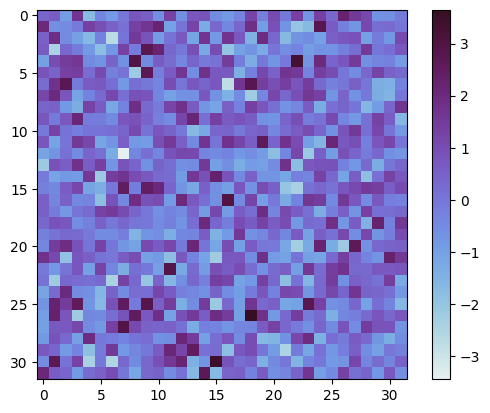

In [4]:
# test model out quickly
# with torch.autograd.profiler.profile(use_device='cuda') as prof:
img = sample_images(model, (1,1,im_size,im_size), num_steps=5)
# print(prof.key_averages().table(sort_by="cuda_time_total"))
img = img[-1].squeeze().cpu().numpy()
plt.imshow(img, cmap=cmocean.cm.dense)
plt.colorbar() # note that our flow model is normalized to [-1,1]

(46, 46)


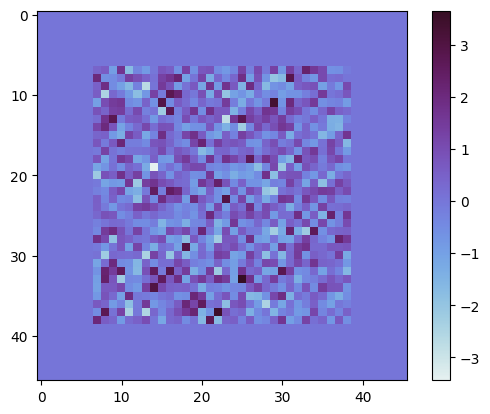

In [5]:
img_padded = radon.pad_image(img)
plt.imshow(img_padded, cmap=cmocean.cm.dense)
plt.colorbar()
print(img_padded.shape)

(100, 46)


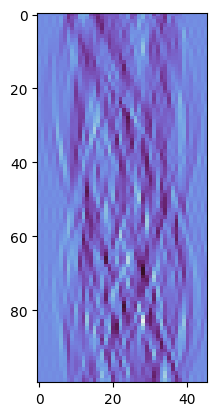

In [6]:
N = 100 # number of projection angles
img_radon = radon.radon_transform(img, N=N)
print(img_radon.shape)
plt.imshow(img_radon.real, cmap=cmocean.cm.dense) # high angular sampling rate

In [ ]:
# demonstrate backprojection
img_backproj = radon.iradon_transform(img_radon)
plt.imshow(img_backproj.real, cmap=cmocean.cm.dense) # high angular sampling
plt.colorbar()

(5, 46)


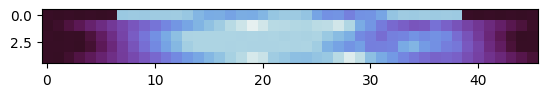

In [ ]:
# try again with a lower angular sampling rate
N = 5
img_radon = radon.radon_transform(img, N=N)
print(img_radon.shape)
plt.imshow(img_radon.real, cmap=cmocean.cm.dense) 

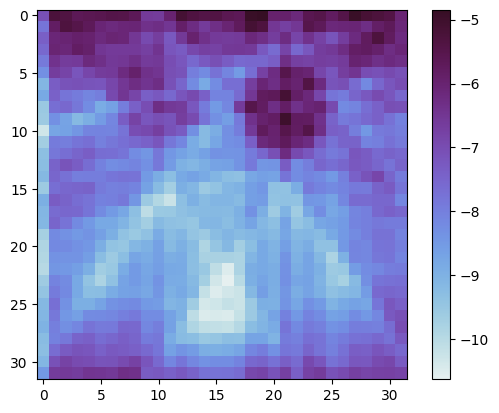

In [ ]:
# demonstrate backprojection
img_backproj = radon.iradon_transform(img_radon)
plt.imshow(img_backproj.real, cmap=cmocean.cm.dense) # high angular sampling
plt.colorbar()

## D-flow algorithm
- initialize $x_0$, either using variance preserving blend, or just sampling $x_0 \sim p_0$. 
- solve the flow ode with $u_t, x_0$.
- perform an optimization step:
$$
\min_{x_0 \in \mathbb{R}^d} \mathcal{L}(\psi_1(x_0)).
$$
- optimization is done with LBFGS (limited memory BFGS). << We need to figure out how the authors manage to actually do this without exploding our gpus.

In [ ]:
from typing import Callable, Dict, List, Optional

from torch import autocast
from torchdiffeq import odeint_adjoint 
import torch.nn as nn


def inverse_loss_fn(x, y):
    """
    Loss function for the inverse problem.
    """
    device = x.device
    if isinstance(x, np.ndarray):
        x= torch.tensor(x, device=device, dtype=torch.float32)
    if isinstance(y, np.ndarray):
        y = torch.tensor(y, device=device, dtype=torch.float32)

    x = x.float()
    y = y.float()


    loss = torch.mean((x - y) ** 2)

    return loss


def ode_integrate(ode_func: nn.Module,
                  init_x: torch.Tensor,
                  ode_opts: Dict = {},
                  t_eps: float = 0,
                  init_t: float = 0.,
                  final_t: float = 1.,
                  t_arr: Optional[List[float]] = None,
                  num_steps: int = 5,
                  intermediate_points: bool = False
      ) -> torch.Tensor:

    if t_arr is None:
        t = torch.linspace(init_t - t_eps, final_t, num_steps).to(init_x.device)
    else:
        t = torch.tensor(t_arr, dtype=torch.float32, device=init_x.device)

    ode_opts = {
        "atol": 1e-5, 
        "rtol": 1e-5, 
        "method": "euler", # "dopri5", "rk4", "euler", "adams", "bdf"
        **ode_opts
    }

    z = odeint(
        func = lambda t, x: ode_func(x, t.expand(x.shape[0])),
        y0 = init_x,
        t = t,
        **ode_opts
    )

    if not intermediate_points:
        return z[-1]
    return z


In [ ]:

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)


2027809


In [ ]:
from torch.autograd.functional import vjp, jvp
from torch.autograd.functional import jacobian
from tqdm import tqdm

m = 1024
# I found in certain cases this might be faster than using torch.autograd to find the singular values
def lanczos_singular_values(
    x: torch.Tensor, 
    model: nn.Module, 
    m: int = 100
) -> torch.Tensor:
    device = x.device
    n = 32**2
    q = torch.randn((n,), device=device)
    q = q / torch.norm(q, 2)
    Q = [q.clone()]
    alpha = []
    beta = []

    for i in tqdm(range(m), desc="Lanczos iterations"):
        q_reshaped = Q[-1].reshape(1, 1, 32, 32)

        def f(x_):
            return ode_integrate(model, x_, num_steps=5, intermediate_points=False).view(-1)

        # JVP: J @ q
        _, jvp_result = jvp(f, (x,), (q_reshaped,))
        # VJP: compute Jacobian^T @ (Jacobian @ q)
        _, vjp_result = vjp(lambda x: f(x), x, v=jvp_result)
        z = vjp_result.view(-1)  # not vjp_result[0]

        if i > 0:
            z = z - beta[-1] * Q[-2]
        a = torch.dot(Q[-1], z)
        alpha.append(a)
        z = z - a * Q[-1]

        # full reorthogonalization
        for prev_q in Q:
            z -= torch.dot(prev_q, z) * prev_q

        b = torch.norm(z, 2)
        if b < 1e-7:
            break
        beta.append(b)
        Q.append(z / b)

    # Tridiagonal matrix
    T = torch.zeros((len(alpha), len(alpha)), device=device)
    for i in range(len(alpha)):
        T[i, i] = alpha[i]
        if i + 1 < len(alpha):
            T[i, i + 1] = beta[i]
            T[i + 1, i] = beta[i]

    eigvals = torch.linalg.eigvalsh(T)
    return torch.flip(torch.sqrt(torch.clamp(eigvals, min=0)), dims=(0,))


init_x = torch.randn((1, 1, im_size, im_size), device=device)
init_x.requires_grad = True
# test our function... by comparing against the full svd
time_start_torch = time.time()
jac_dim = im_size * im_size
jac = jacobian(lambda x: ode_integrate(model, x, num_steps=5, intermediate_points=False).view(-1), inputs=init_x, vectorize=True)
jac = jac.view(jac_dim, jac_dim)

_, S_true, _ = torch.linalg.svd(jac, full_matrices=False)
time_end_torch = time.time()
print(f"Full jacobian + svd took {time_end_torch - time_start_torch:.2f} seconds")
"""
time_start_lanczos = time.time()
S = lanczos_singular_values(init_x, model, m=m)
time_end_lanczos = time.time()
print(f"Lanczos took {time_end_lanczos - time_start_lanczos:.2f} seconds")
plt.semilogy(S_true.cpu().numpy()[:50], label='True')
plt.semilogy(S.cpu().numpy(), label='Lanczos')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Singular Value (log scale)')
plt.title('Singular Values of the Jacobian')
plt.grid()
plt.show()

# l1 error between dominant singular values
l1_error = torch.sum(torch.abs(S_true[:100] - S[:100])) / torch.sum(torch.abs(S_true[:100]))
print(f"L1 error between singular values: {l1_error:.4f}")
"""

Full jacobian + svd took 9.85 seconds


'\ntime_start_lanczos = time.time()\nS = lanczos_singular_values(init_x, model, m=m)\ntime_end_lanczos = time.time()\nprint(f"Lanczos took {time_end_lanczos - time_start_lanczos:.2f} seconds")\nplt.semilogy(S_true.cpu().numpy()[:50], label=\'True\')\nplt.semilogy(S.cpu().numpy(), label=\'Lanczos\')\nplt.legend()\nplt.xlabel(\'Index\')\nplt.ylabel(\'Singular Value (log scale)\')\nplt.title(\'Singular Values of the Jacobian\')\nplt.grid()\nplt.show()\n\n# l1 error between dominant singular values\nl1_error = torch.sum(torch.abs(S_true[:100] - S[:100])) / torch.sum(torch.abs(S_true[:100]))\nprint(f"L1 error between singular values: {l1_error:.4f}")\n'

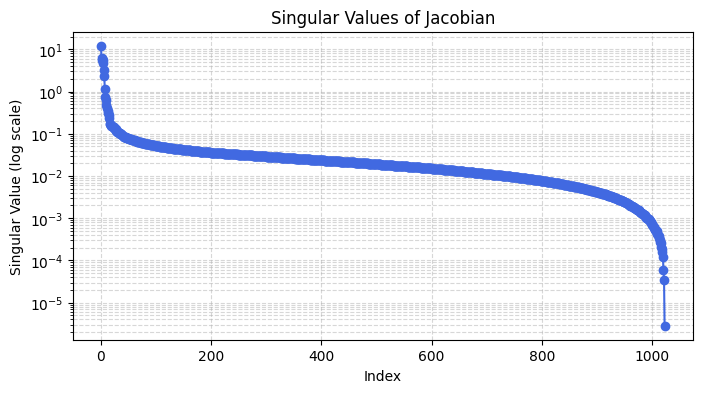

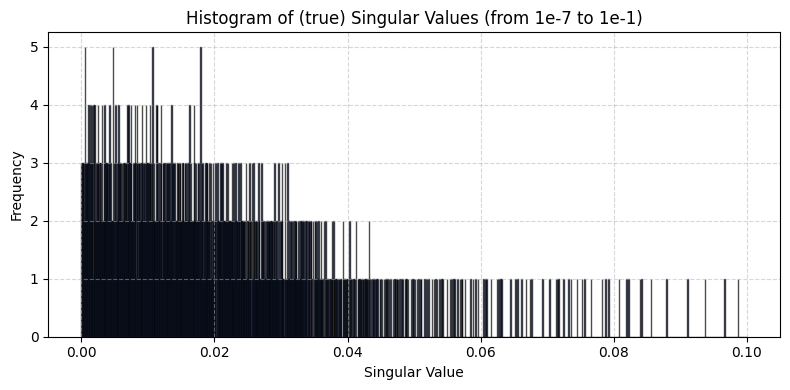

In [ ]:
# semilog scale, plot only the first 100 singular values
plt.figure(figsize=(8, 4))
plt.semilogy(S_true[:jac_dim].cpu().numpy(), marker='o', linestyle='-', color='royalblue', label='True')
plt.title('Singular Values of Jacobian')
plt.xlabel('Index')
plt.ylabel('Singular Value (log scale)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)

"""
# also plot the lanczos singular values
plt.semilogy(S.cpu().numpy(), marker='x', linestyle='--', color='red', label='Lanczos')
plt.legend()
plt.title('Singular Values of Jacobian (True vs Lanczos)')
plt.xlabel('Index')
plt.ylabel('Singular Value (log scale)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
"""
# make a histogram
plt.figure(figsize=(8, 4))
# on a log scale
plt.hist(S_true[:jac_dim].cpu().numpy(), bins=jac_dim, color='royalblue', alpha=0.7, edgecolor='black', range=(1e-7, 1e-1))
plt.title('Histogram of (true) Singular Values (from 1e-7 to 1e-1)')
plt.xlabel('Singular Value')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()

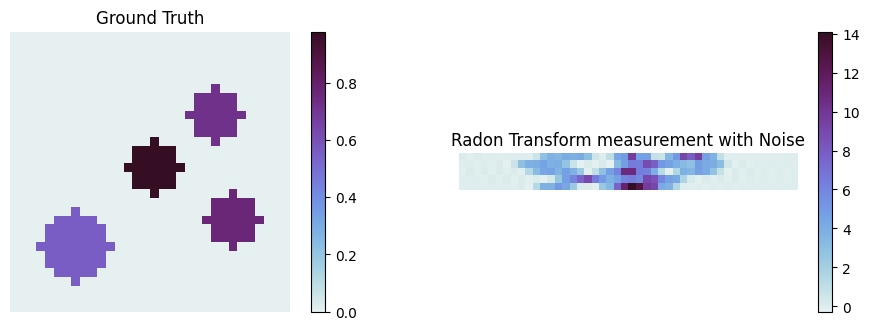

In [ ]:
# load data and select a random ground truth from test set
test_data = torch.load(f'data/dataset-{im_size}.pt')["test"]
idx = np.random.randint(0, len(test_data))
gt = test_data[idx].to(device).unsqueeze(0)

# apply radon transform, and apply multiplicative noise
img_radon = radon.radon_transform(gt.squeeze().cpu().numpy(), N=5)
img_radon = torch.tensor(img_radon, device=device, dtype=torch.float32).unsqueeze(0)
img_radon = img_radon.unsqueeze(0)  # add batch dimension   

# mult noise
img_radon = (1 + 0.1 * torch.randn_like(img_radon)) * img_radon
# plot gt, plot img_radon, plot initial guess in x_0 space, and plot flow realization
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(gt.squeeze().cpu().numpy(), cmap=cmocean.cm.dense)
plt.title('Ground Truth')
plt.axis('off')
plt.colorbar()
plt.subplot(2, 2, 2)
plt.imshow(img_radon.squeeze().cpu().numpy(), cmap=cmocean.cm.dense)
plt.title('Radon Transform measurement with Noise')
plt.axis('off')
plt.colorbar()

In [ ]:
# getting normalization constants
train_min, train_max = torch.min(torch.load(f'data/dataset-{im_size}.pt')["train"]), torch.max(torch.load(f'data/dataset-{im_size}.pt')["train"])

In [ ]:
max_iter = 1000
optim_steps = 1000
target_cost = .015
time_limit = 500
lr = 0.2
x1_trajectory = []
init_x = torch.randn((1, 1, im_size, im_size), device=device, dtype=torch.float32)
init_x.requires_grad = True
y = img_radon
# history_size depends on your VRAM.
# optimizer = optim.LBFGS([init_x], max_iter=max_iter, lr=lr, line_search_fn='strong_wolfe', history_size=10)
# or we can try sgd
optimizer = torch.optim.SGD([init_x], lr=lr, nesterov=True, momentum=0.9)
# optimizer = optim.Adam([init_x], lr=lr, betas=(0.9, 0.99), eps=1e-8, weight_decay=0.01)

svd_traj = []

metrics = {'loss': CatMetric(), 
           'cost': CatMetric(), 
           'reg': CatMetric(),
           'norm_x0': CatMetric(), 
           'std_x0': CatMetric(), 
           'mean_x0': CatMetric(), 
           'time': CatMetric()
           }
start_time = time.time()
# add metrics to tqdm
for step in range(optim_steps):
    def closure():
        global loss
        global x1
        optimizer.zero_grad()

        reg_loss = torch.tensor(0.).to(init_x)

        ### solve for x1
        x1 = ode_integrate(ode_func=model, init_x =init_x, num_steps=5)
        # unnormalize x1
        x1 = 0.5 * (x1 + 1.0) * (train_max - train_min) + train_min
        
        # degraded_x1 = H(x1)
        degraded_x1 = radon.radon_transform(x1, N=N)
        cost = inverse_loss_fn(degraded_x1, y)
        loss = cost 

        norm_x0 = init_x.norm()
        std_x0 = init_x.std()
        mean_x0 = init_x.mean()

        metrics['norm_x0'].update(norm_x0.item())
        metrics['std_x0'].update(std_x0.item())
        metrics['mean_x0'].update(mean_x0.item())
        metrics['cost'].update(cost.item())
        metrics['reg'].update(reg_loss.item())
        metrics['loss'].update(loss.item())

        loss.backward()

        if step % 10 == 0 or step == optim_steps - 1:
            with torch.no_grad():
                # compute singular value decay of jacobian at x1
                jacobian_x1 = jacobian(lambda x: ode_integrate(model, x, num_steps=5, intermediate_points=False).view(-1), inputs=x1, vectorize=True)
                jacobian_x1 = jacobian_x1.view(1024, 1024)

                _, svd_x1, _ = torch.linalg.svd(jacobian_x1, full_matrices=False)
                svd_traj.append(svd_x1)

        return loss


    optimizer.step(closure)
    


    x1_trajectory.append(x1.detach().cpu().numpy())


    elapsed = time.time() - start_time
    metrics['time'].update(elapsed)

    elapsed = elapsed/60
    if step % 10 == 0 or step == optim_steps - 1:
        print(f"[Step {step}] Loss {loss.item()}"
            + f"| x_init min {init_x.detach().min()} max {init_x.detach().max()}" + f"| time: {elapsed} mins")

    if target_cost is not None:
        mets_cost = metrics['cost'].compute()
        if mets_cost.dim() > 0:
            mets_cost = mets_cost[-1]
        last_cost = mets_cost.item()
        if last_cost <= target_cost:
            print(f'reached cost of {last_cost}')
            break

    if time_limit is not None:
        elapsed = (time.time() - start_time)/60 # time in minutes
        if elapsed > time_limit:
            print(f'reached time limit of {time_limit} mins')
            break

with torch.no_grad():
    x1 = ode_integrate(model, init_x)
x1_trajectory.append(x1.detach().cpu().numpy())



[Step 0] Loss 8.5579833984375| x_init min -3.4459900856018066 max 3.9844465255737305| time: 0.1625998854637146 mins
[Step 10] Loss 2.6819541454315186| x_init min -3.477102041244507 max 4.20937967300415| time: 0.36513851483662924 mins
[Step 20] Loss 1.7781695127487183| x_init min -3.518206834793091 max 4.144780158996582| time: 0.5676041881243388 mins
[Step 30] Loss 0.43210411071777344| x_init min -3.49535870552063 max 4.423688888549805| time: 0.7701761682828268 mins
[Step 40] Loss 0.1861325055360794| x_init min -3.4506945610046387 max 4.472071647644043| time: 0.9724016865094502 mins
[Step 50] Loss 0.1249302327632904| x_init min -3.3979620933532715 max 4.506587505340576| time: 1.1747090816497803 mins
[Step 60] Loss 0.11008638888597488| x_init min -3.358165740966797 max 4.497417449951172| time: 1.3764862855275473 mins
[Step 70] Loss 0.10274031013250351| x_init min -3.327903985977173 max 4.483297348022461| time: 1.5785240451494853 mins
[Step 80] Loss 0.09878408908843994| x_init min -3.3080

KeyboardInterrupt: 

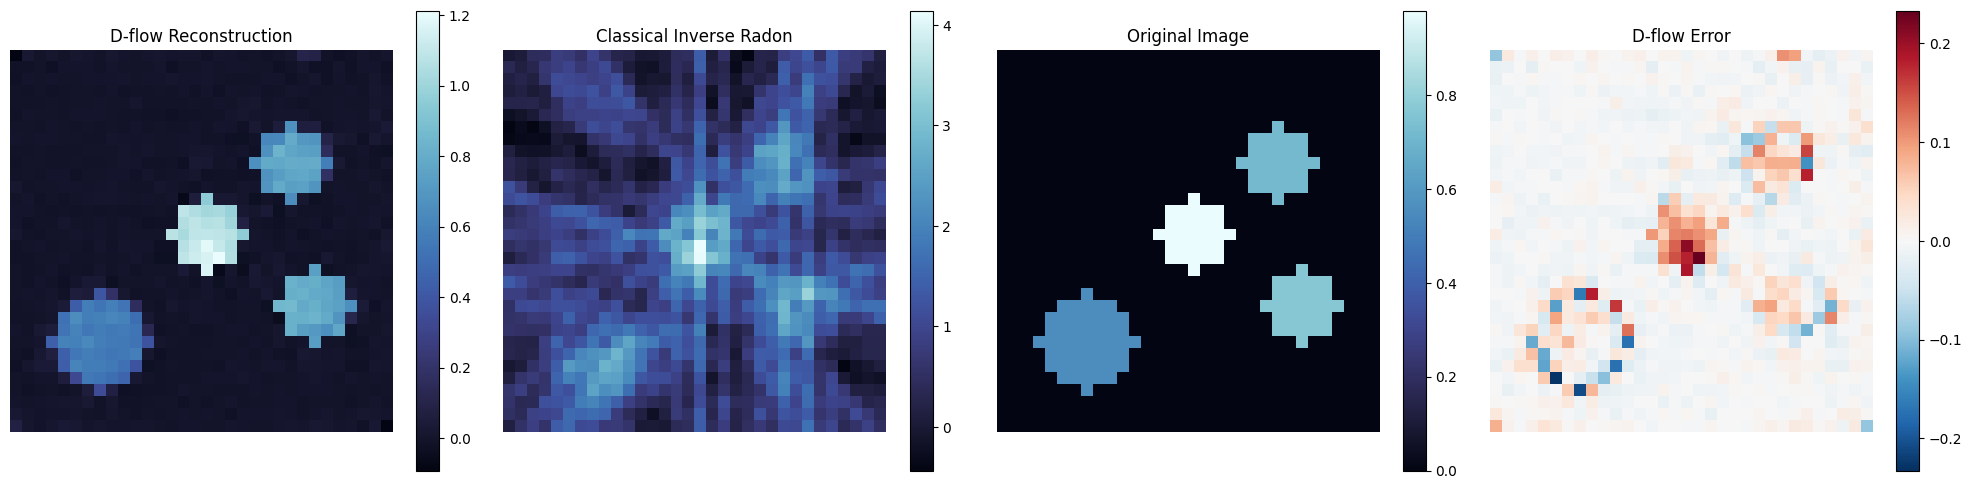

D-flow Results
MSE: 0.001204
MAE: 0.017464
PSNR: 29.01 dB

Classical Inverse Radon Results
MSE: 1.098527
MAE: 0.879533
PSNR: -0.59 dB


In [ ]:
import warnings

# Suppress warnings from transforms
warnings.filterwarnings('ignore', category=RuntimeWarning)
np.seterr(divide='ignore', invalid='ignore')

# plot error and final result
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Reconstructed image (D-flow)
im1 = axes[0].imshow(x1.squeeze().detach().cpu().numpy(), cmap=cmocean.cm.ice)
axes[0].set_title('D-flow Reconstruction')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0])

# Classical inverse radon transform
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    classical_recon = radon.iradon_transform(img_radon.squeeze().cpu().numpy())

im2 = axes[1].imshow(classical_recon.real, cmap=cmocean.cm.ice)
axes[1].set_title('Classical Inverse Radon')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1])

# Original image
im3 = axes[2].imshow(gt.squeeze().cpu().numpy(), cmap=cmocean.cm.ice)
axes[2].set_title('Original Image')
axes[2].axis('off')
plt.colorbar(im3, ax=axes[2])

# Error/difference (D-flow vs Original)
error = x1.squeeze().detach().cpu().numpy() - gt.squeeze().cpu().numpy()
im4 = axes[3].imshow(error, cmap='RdBu_r', vmin=-np.abs(error).max(), vmax=np.abs(error).max())
axes[3].set_title('D-flow Error')
axes[3].axis('off')
plt.colorbar(im4, ax=axes[3])

plt.tight_layout()
plt.show()

# Print comparison metrics
mse_dflow = np.mean(error**2)
mae_dflow = np.mean(np.abs(error))
psnr_dflow = 20 * np.log10(np.max(gt.squeeze().cpu().numpy()) / np.sqrt(mse_dflow))

error_classical = classical_recon.real - gt.squeeze().cpu().numpy()
mse_classical = np.mean(error_classical**2)
mae_classical = np.mean(np.abs(error_classical))
psnr_classical = 20 * np.log10(np.max(gt.squeeze().cpu().numpy()) / np.sqrt(mse_classical))

print("D-flow Results")
print(f"MSE: {mse_dflow:.6f}")
print(f"MAE: {mae_dflow:.6f}")
print(f"PSNR: {psnr_dflow:.2f} dB")

print("\nClassical Inverse Radon Results")
print(f"MSE: {mse_classical:.6f}")
print(f"MAE: {mae_classical:.6f}")
print(f"PSNR: {psnr_classical:.2f} dB")

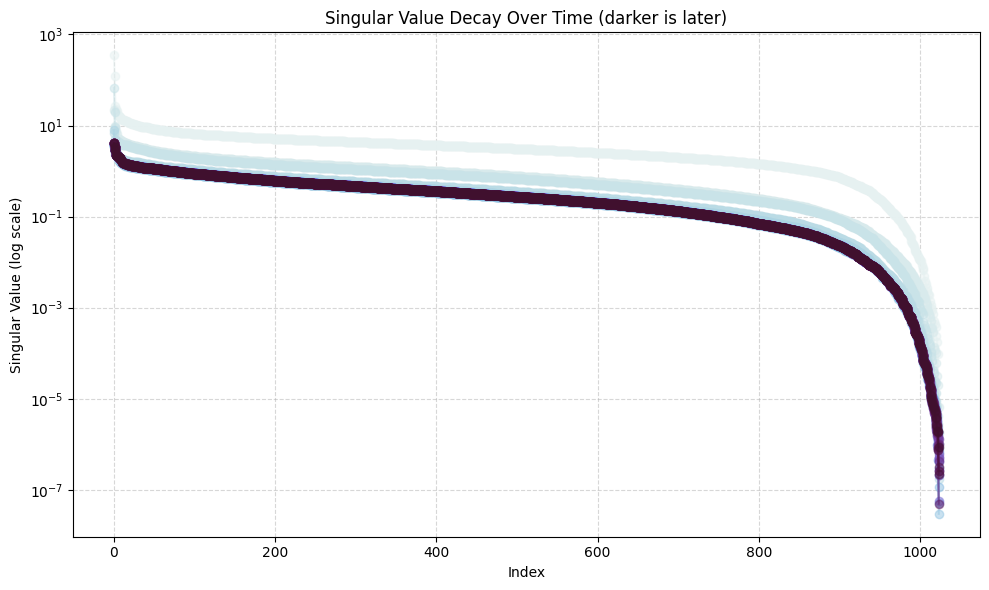

In [ ]:
# Plot singular values over time
plt.figure(figsize=(10, 6))
for i, svd in enumerate(svd_traj):
    plt.semilogy(svd.cpu().numpy(), marker='o', linestyle='-', alpha=0.5, label=f'Iteration {i}', color=cmocean.cm.dense(i / len(svd_traj)))
plt.title('Singular Value Decay Over Time (darker is later)')
plt.xlabel('Index')
plt.ylabel('Singular Value (log scale)')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()